# **Agents Estimation and AQI prediction**

After finding the best model for each agent, use them to compute the overall pollution estimations and AQI values.

## **Notebook Setup**

In [40]:
%load_ext autoreload
%autoreload 2

from datetime import datetime

from utils import *

datasets_folder = './datasets'
verbosity = 0
figsize = (18,4)

tf.config.set_visible_devices([], 'GPU')
print(tf.config.list_physical_devices('GPU'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [41]:
pollution_data = read_and_preprocess_dataset(datasets_folder, 'pollution', v=verbosity)
traffic_data = read_and_preprocess_dataset(datasets_folder, 'traffic', v=verbosity, radius=2)
weather_data = read_and_preprocess_dataset(datasets_folder, 'weather', v=verbosity)

stations = pollution_data.keys()

In [42]:
station_data = {}
station_dists = {}
date_encoding = 'radial_months-sin-cos_days_hours'

for station in stations:
    station_data[station], station_dists[station] = prepare_station_data_for_training(
        pollution_data[station], 
        traffic_data[station], 
        weather_data, 
        encoding_method=date_encoding,
        # weather merging parameters:
        aggregations = DEFAULT_AGGREGATIONS,
        max_min_columns = DEFAULT_MAX_MIN_COLUMNS, 
        # traffic merging parameters:
        bin_size = 3,
        offset = 0
    )
    
    print(f'Station {station} agents: ',', '.join(list(station_data[station].keys())))

n_hour_features = len(station_data['GIARDINI MARGHERITA']['NO2'].columns) - 1 # -1 because Agent_value is the target
n_daily_features = len(station_data['GIARDINI MARGHERITA']['PM2.5'].columns) - 1 # -1 because Agent_value is the target
print(f'Total number of hourly features: {n_hour_features}')
print(f'Total number of daily features: {n_daily_features}')

Station GIARDINI MARGHERITA agents:  NO2, O3, PM10, PM2.5
Station PORTA SAN FELICE agents:  C6H6, CO, NO2, PM10, PM2.5
Station VIA CHIARINI agents:  NO2, O3, PM10
Total number of hourly features: 24
Total number of daily features: 33


In [43]:
train_split_date = datetime(2023,12,31,23)
target = 'Agent_value'

In [44]:
train_sets = {}
test_sets = {}

for station in stations:
    train_sets[station] = {}
    test_sets[station] = {}
    for agent in station_data[station].keys():
        train_sets[station][agent] = {}
        test_sets[station][agent] = {}

        x_train, y_train, x_test, y_test = create_train_test(station_data[station][agent], train_split_date, y=target)

        train_sets[station][agent]['x'] = x_train
        train_sets[station][agent]['y'] = y_train
        test_sets[station][agent]['x'] = x_test
        test_sets[station][agent]['y'] = y_test

## **Agents Estimations**

Prepare a dictionary containing all the models to use for each agent of each station, accordingly to the results obtained in the [model selection notebook](./5-model-selection.ipynb).

### **Hourly models**

#### XGBoost

In [45]:
xgbr_params = {
    'objective': "reg:absoluteerror",
    'n_estimators': 180,
    'max_depth': 6,
    'learning_rate': 0.07,
    'subsample': 0.9
}

xgbr = ('XGB Regressor', xgb.XGBRegressor, xgbr_params, None, False)

#### FFNN

In [46]:
ffnn2_params = {
    'input_size': n_hour_features,
    'neurons': [512, 256, 128],
    'dropout': 0.3,
    'optimizer': Adam(learning_rate=1e-2),
    'loss': 'mean_absolute_error'
}

ffnn2_train_params = {
    'epochs':10,
    'batch_size':32,
}

FFNN2 = ('Feed Forward NN 2', build_ffnn_model, ffnn2_params, ffnn2_train_params, False)

#### 1D Convolution

In [47]:
conv_params = {
    'time_steps': 8,
    'n_features': n_hour_features,
    'filters': 64,
    'optimizer': Adam(learning_rate=3e-3),
    'loss': 'mean_absolute_error'
}

conv_train_params = {
    'epochs': 10,
    'batch_size': 64
}

conv = ('Conv1D', build_conv_model, conv_params, conv_train_params, True)

In [48]:
conv2_params = {
    'time_steps': 8,
    'n_features': n_hour_features,
    'filters': [64, 32],
    'optimizer': Adam(learning_rate=3e-3),
    'loss': 'mean_absolute_error'
}

conv2_train_params = {
    'epochs': 10,
    'batch_size': 64,
}

conv2 = ('Conv1D 2', build_conv_model, conv2_params, conv2_train_params, True)

In [49]:
conv3_params = {
    'time_steps': 8,
    'n_features': n_hour_features,
    'filters': [64, 32],
    'optimizer': Adam(learning_rate=3e-3),
    'loss': 'mean_absolute_error'
}

conv3_train_params = {
    'epochs': 20,
    'batch_size': 32,
}

conv3 = ('Conv1D 3', build_conv_model, conv3_params, conv3_train_params, True)

### **Daily Models**

#### FFNN

In [50]:
ffnn_daily_params = {
    'input_size': n_daily_features,
    'neurons': [1024, 512, 256, 128],
    'optimizer': Adam(learning_rate=3e-4),
    'loss': 'mean_absolute_error'
}

ffnn_daily_train_params = {
    'epochs':20,
    'batch_size':32
}

FFNN_daily = ('Feed Forward NN', build_ffnn_model, ffnn_daily_params, ffnn_daily_train_params, False)

In [51]:
bn_ffnn_daily_params = {
    'input_size': n_daily_features,
    'neurons': [1024, 512, 256, 128],
    'batch_norm': True,
    'dropout': 0.2,
    'optimizer': Adam(learning_rate=3e-4),
    'loss': 'mean_absolute_error'
}

bn_ffnn_daily_train_params = {
    'epochs':20,
    'batch_size':32,
}

FFNN_BN_daily = ('Feed Forward NN BatchNorm', build_ffnn_model, bn_ffnn_daily_params, bn_ffnn_daily_train_params, False)

#### Random Forest

In [52]:
rfr_params = {
    'n_estimators':100,
    'max_depth':10,
    'min_samples_leaf': 5,
    'max_features': 'log2',
}

rfr = ('Random Forest Regressor 2', RandomForestRegressor, rfr_params, None, False)

### **Training**

In [53]:
models = {
    'GIARDINI MARGHERITA':{
        'NO2': conv2, 
        'O3': conv3,
        'PM10': FFNN_BN_daily,
        'PM2.5': FFNN_daily 
    },
    'PORTA SAN FELICE':{
        'C6H6': conv2, 
        'CO': xgbr, 
        'NO2': FFNN2,
        'PM10':FFNN_daily,  
        'PM2.5':FFNN_daily 
    },
    'VIA CHIARINI':{
        'NO2': xgbr, 
        'O3': conv, 
        'PM10':rfr 
    }
}

In [ ]:
agents_predictions = train_agents(
    models, train_sets, test_sets,
    model_out_folder='./models'
)

Predicting NO2 in GIARDINI MARGHERITA using Conv1D 2...
Predicting O3 in GIARDINI MARGHERITA using Conv1D 3...
Predicting PM10 in GIARDINI MARGHERITA using Feed Forward NN BatchNorm...
Predicting PM2.5 in GIARDINI MARGHERITA using Feed Forward NN...
Predicting C6H6 in PORTA SAN FELICE using Conv1D 2...
Predicting CO in PORTA SAN FELICE using XGB Regressor...
Predicting NO2 in PORTA SAN FELICE using Feed Forward NN 2...
Predicting PM10 in PORTA SAN FELICE using Feed Forward NN...
Predicting PM2.5 in PORTA SAN FELICE using Feed Forward NN...
Predicting NO2 in VIA CHIARINI using XGB Regressor...
Predicting O3 in VIA CHIARINI using Conv1D...
Predicting PM10 in VIA CHIARINI using Random Forest Regressor 2...


In [55]:
metrics_predictions = training_results_to_dataframe(agents_predictions, multiple_models=False)
metrics_predictions

,Station,Agent,root_mean_squared_error,r2_score,mean_absolute_error,mean_squared_error
0,GIARDINI MARGHERITA,NO2,0.558822,0.556981,0.374598,0.312282
1,GIARDINI MARGHERITA,O3,0.342967,0.867876,0.256808,0.117626
2,GIARDINI MARGHERITA,PM10,0.714385,0.434603,0.502577,0.510346
3,GIARDINI MARGHERITA,PM2.5,0.708156,0.502087,0.495409,0.501486
4,PORTA SAN FELICE,C6H6,0.566722,0.651339,0.354699,0.321174
5,PORTA SAN FELICE,CO,0.666063,0.575716,0.511849,0.443640
6,PORTA SAN FELICE,NO2,0.914593,-0.548335,0.759277,0.836480
7,PORTA SAN FELICE,PM10,0.704898,0.508156,0.479152,0.496881
8,PORTA SAN FELICE,PM2.5,0.629137,0.615791,0.441499,0.395814
9,VIA CHIARINI,NO2,0.519502,0.562460,0.392193,0.269882


## **AQI calculation**

The steps to compute the Air Quality Index are the same illustrated in the [pollution notebook](./1-pollution_preprocessing.ipynb):


- we go back to the original distribution,

In [56]:
agents_predictions_original_dist = agents_predictions.copy()
test_sets_original_dist = test_sets.copy()

for station in stations:
    for agent in agents_predictions_original_dist[station]:
        test_sets_original_dist[station][agent]['y'] = (test_sets_original_dist[station][agent]['y'] * station_dists[station][agent]['std']) + station_dists[station][agent]['mean']
        agents_predictions_original_dist[station][agent]['predictions'] = (agents_predictions_original_dist[station][agent]['predictions'] * station_dists[station][agent]['std']) + station_dists[station][agent]['mean']


- then we compute the AQI of each agent,
- and then we take the maximums for each time step

In [57]:
pred_AQIs_daily = {
    s: {agent: get_AQI(agents_predictions_original_dist[s][agent]['predictions'], 
                        agent=agent, 
                        period='day', 
                        value_column='Agent_value',
                        ) for agent in agents_predictions_original_dist[s].keys()} for s in agents_predictions_original_dist
}

pred_AQI_daily = merge_AQIs(pred_AQIs_daily, period='day')

pred_AQIs_hourly = {
    s: {agent: get_AQI(agents_predictions_original_dist[s][agent]['predictions'],
                       agent=agent,
                       period='hour', 
                       value_column='Agent_value',
                       include_hourly_pm=False
                       ) for agent in agents_predictions_original_dist[s].keys()} for s in agents_predictions_original_dist
}

pred_AQI_hourly = merge_AQIs(pred_AQIs_hourly, period='hour')

In [58]:
true_AQIs_daily = {
    s: {agent: get_AQI(test_sets_original_dist[s][agent]['y'], 
                        agent=agent, 
                        period='day', 
                        value_column='Agent_value',
                        ) for agent in test_sets_original_dist[s].keys()} for s in test_sets_original_dist
}

true_AQI_daily = merge_AQIs(true_AQIs_daily, period='day')

true_AQIs_hourly = {
    s: {agent: get_AQI(test_sets_original_dist[s][agent]['y'],
                       agent=agent,
                       period='hour', 
                       value_column='Agent_value',
                       include_hourly_pm=False
                       ) for agent in test_sets_original_dist[s].keys()} for s in test_sets_original_dist
}

true_AQI_hourly = merge_AQIs(true_AQIs_hourly, period='hour')

- We also compute the difference between the true AQIs and the predicted values, for better comparison.

In [59]:
AQI_diff_daily = {}
AQI_diff_hourly = {}    

for station in true_AQI_hourly:
    AQI_diff_daily[station] = AQI_difference(pred_AQI_daily[station], true_AQI_daily[station])
    AQI_diff_hourly[station] = AQI_difference(pred_AQI_hourly[station], true_AQI_hourly[station])

## **AQI Comparison**

- We define the same risk categories presented in the pollution notebook.

In [60]:
categories = {
    'Good': 0,
    'Moderate': 50,
    'Poor': 100,
    'Very Poor': 150,
    'Severe': 200,
}

### **Hourly AQI**

#### **Visualization**

Station GIARDINI MARGHERITA AQI:


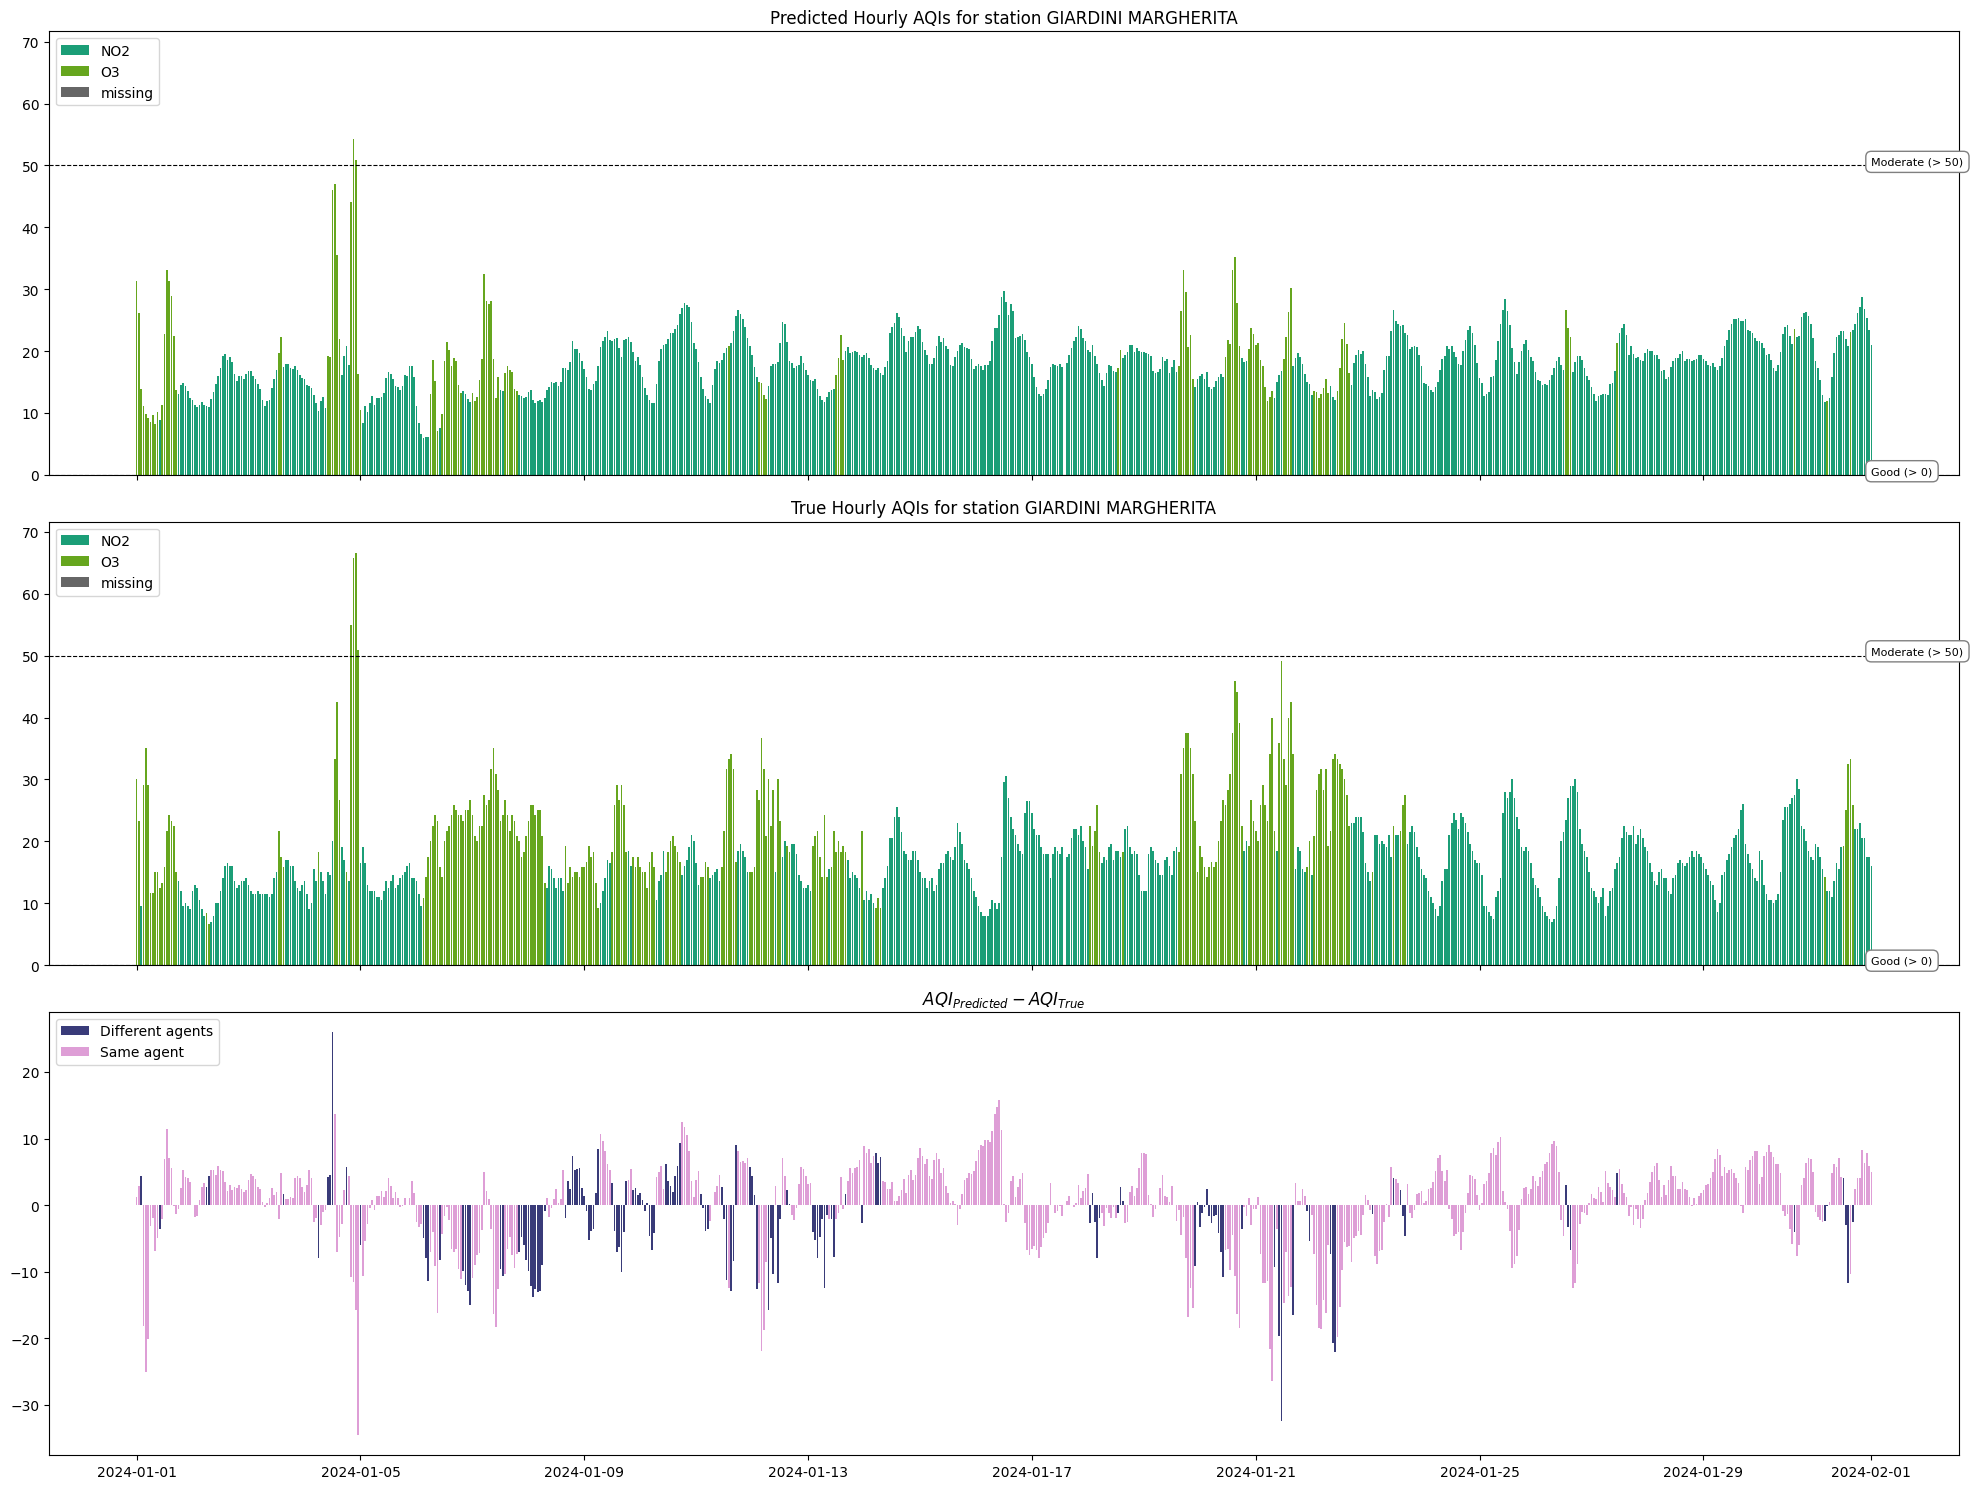

Station PORTA SAN FELICE AQI:


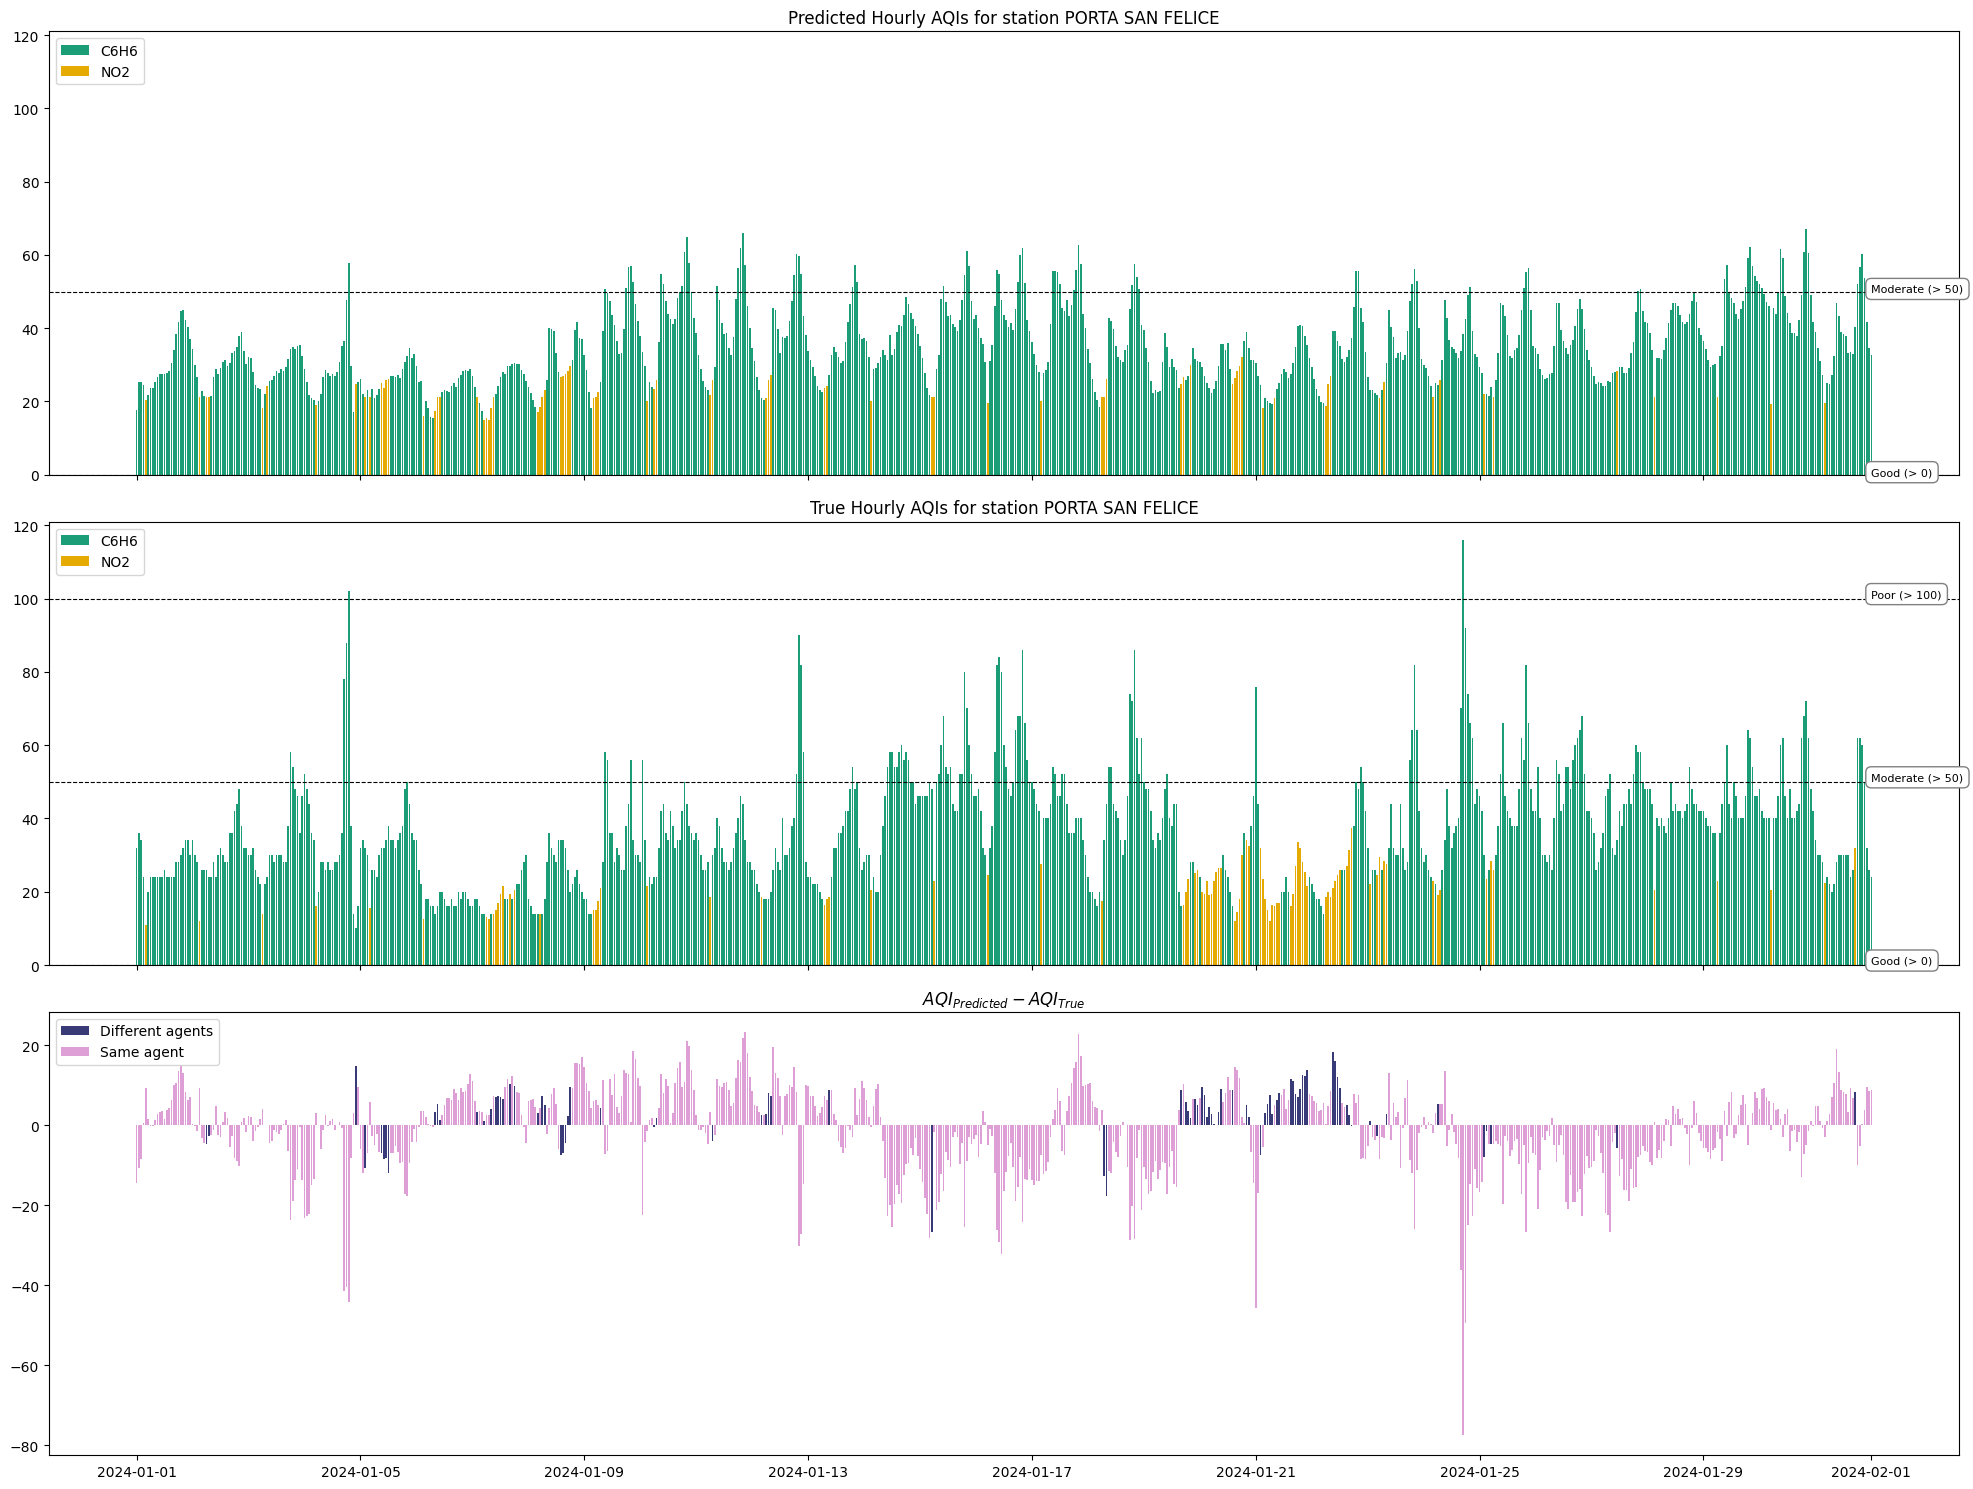

Station VIA CHIARINI AQI:


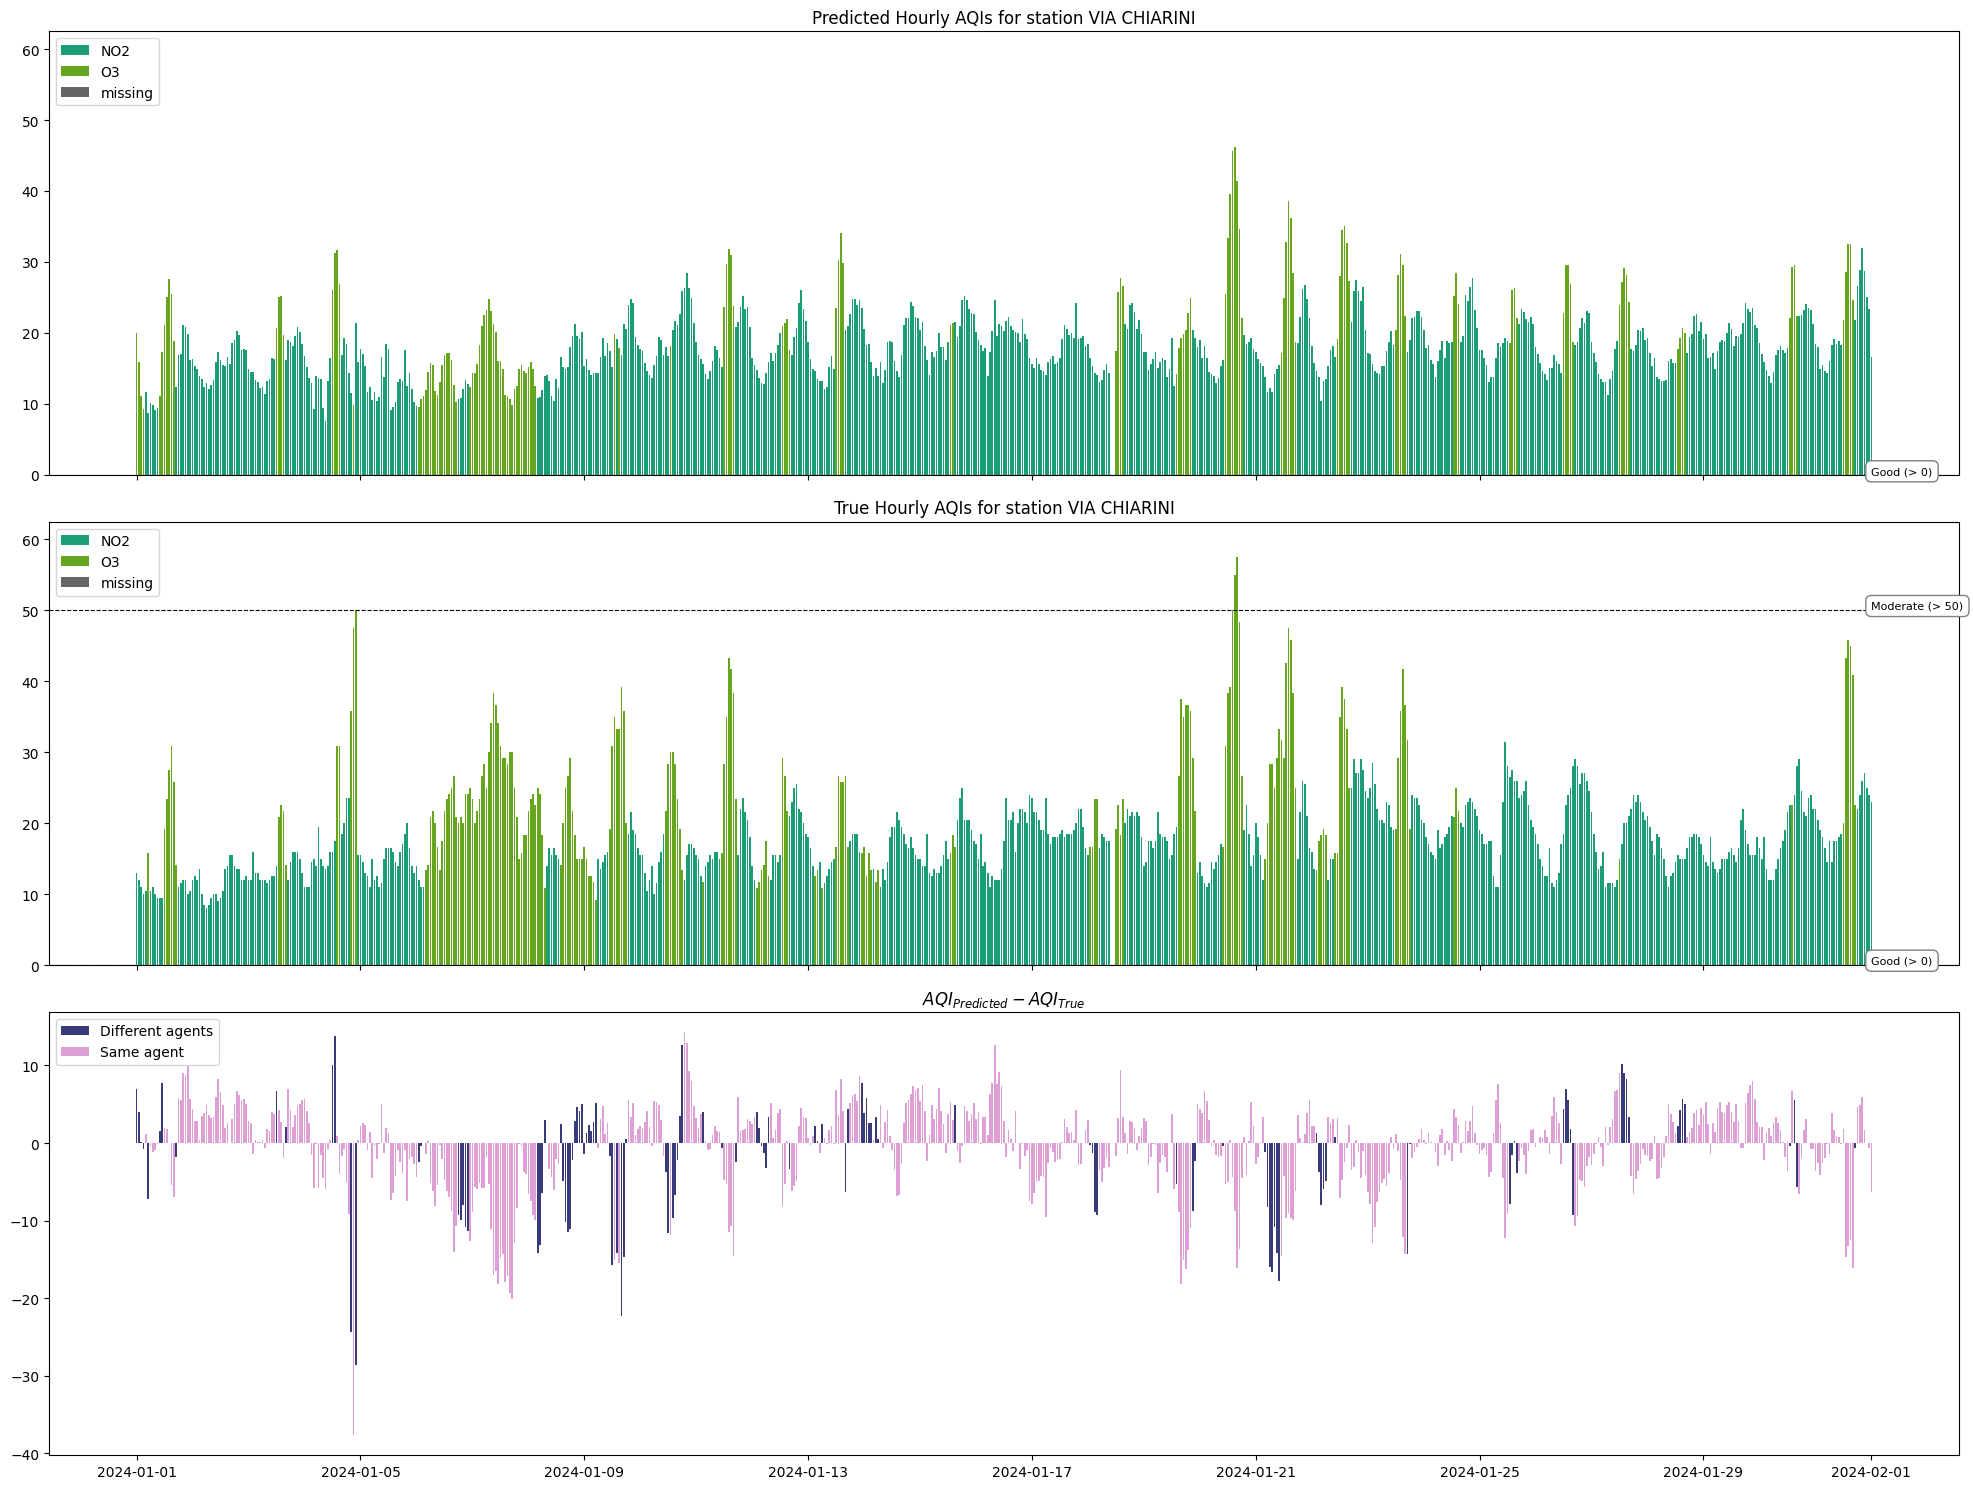

In [61]:
start=datetime(2024,1,1)
end=datetime(2024,2,1)

for station in true_AQIs_hourly:
    print(f'Station {station} AQI:')
    plot_AQI(
        station_AQI=[
            pred_AQI_hourly[station],
            true_AQI_hourly[station],
            AQI_diff_hourly[station]
        ], 
        title=[
            f'Predicted Hourly AQIs for station {station}',
            f'True Hourly AQIs for station {station}',
            r'$AQI_{Predicted} - AQI_{True}$'
        ],
        categories=categories,
        figsize=(20, 5), s=start, e=end)

The predicted AQI trend follows nicely the values obtained by the true values. Anyways, it is hard to predict sudden changes such as really high values.

From the plots, we can also notice a daily period in the AQI values, correctly displaying the capabilities of the model in detecting the hour of the day and acting accordingly.

#### **Metrics**

Station GIARDINI MARGHERITA


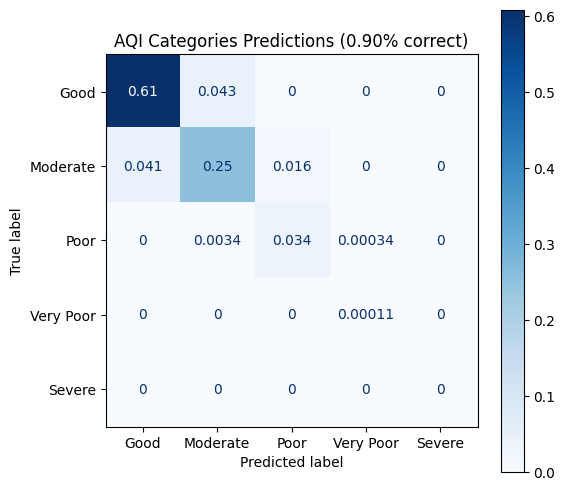

---------------------------------------------
> Absolute Mean AQI Difference: 7.68
> Positive Average AQI Difference: 7.41
> Negative Average AQI Difference: -7.96
> Percentage of Positive Differences: 51.31%
> Percentage of Negative Differences: 48.48%
> Percentage of Agent Values:
   - Same agent: 88.7
   - Different agents: 11.3
Station PORTA SAN FELICE


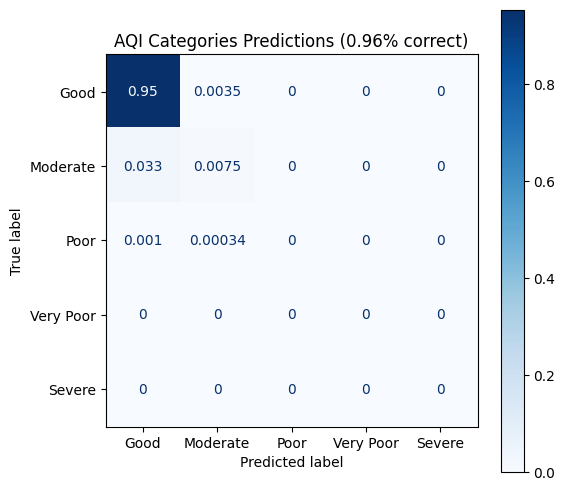

---------------------------------------------
> Absolute Mean AQI Difference: 6.25
> Positive Average AQI Difference: 5.52
> Negative Average AQI Difference: -7.22
> Percentage of Positive Differences: 56.99%
> Percentage of Negative Differences: 42.81%
> Percentage of Agent Values:
   - Same agent: 59.42
   - Different agents: 40.58
Station VIA CHIARINI


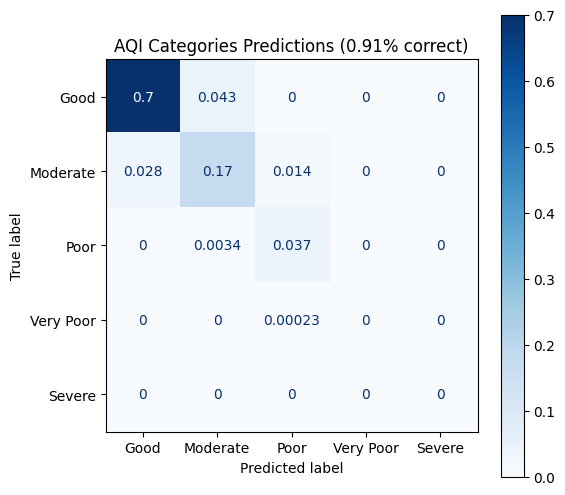

---------------------------------------------
> Absolute Mean AQI Difference: 7.30
> Positive Average AQI Difference: 7.95
> Negative Average AQI Difference: -6.29
> Percentage of Positive Differences: 61.04%
> Percentage of Negative Differences: 38.65%
> Percentage of Agent Values:
   - Same agent: 87.83
   - Different agents: 12.17


In [62]:
for station in stations:
    print('=============================================')
    print(f'Station {station}')
    print('=============================================')
    print_AQI_category_comparison(pred_AQI_hourly[station],true_AQI_hourly[station], categories=categories)
    print('---------------------------------------------')
    print_AQI_difference_metrics(AQI_diff_hourly[station])
    print('=============================================')

The results are really accurate, but most of the AQI fall under the same category *good*.

### **Daily AQI**

#### **Visualization**

Station GIARDINI MARGHERITA AQI:


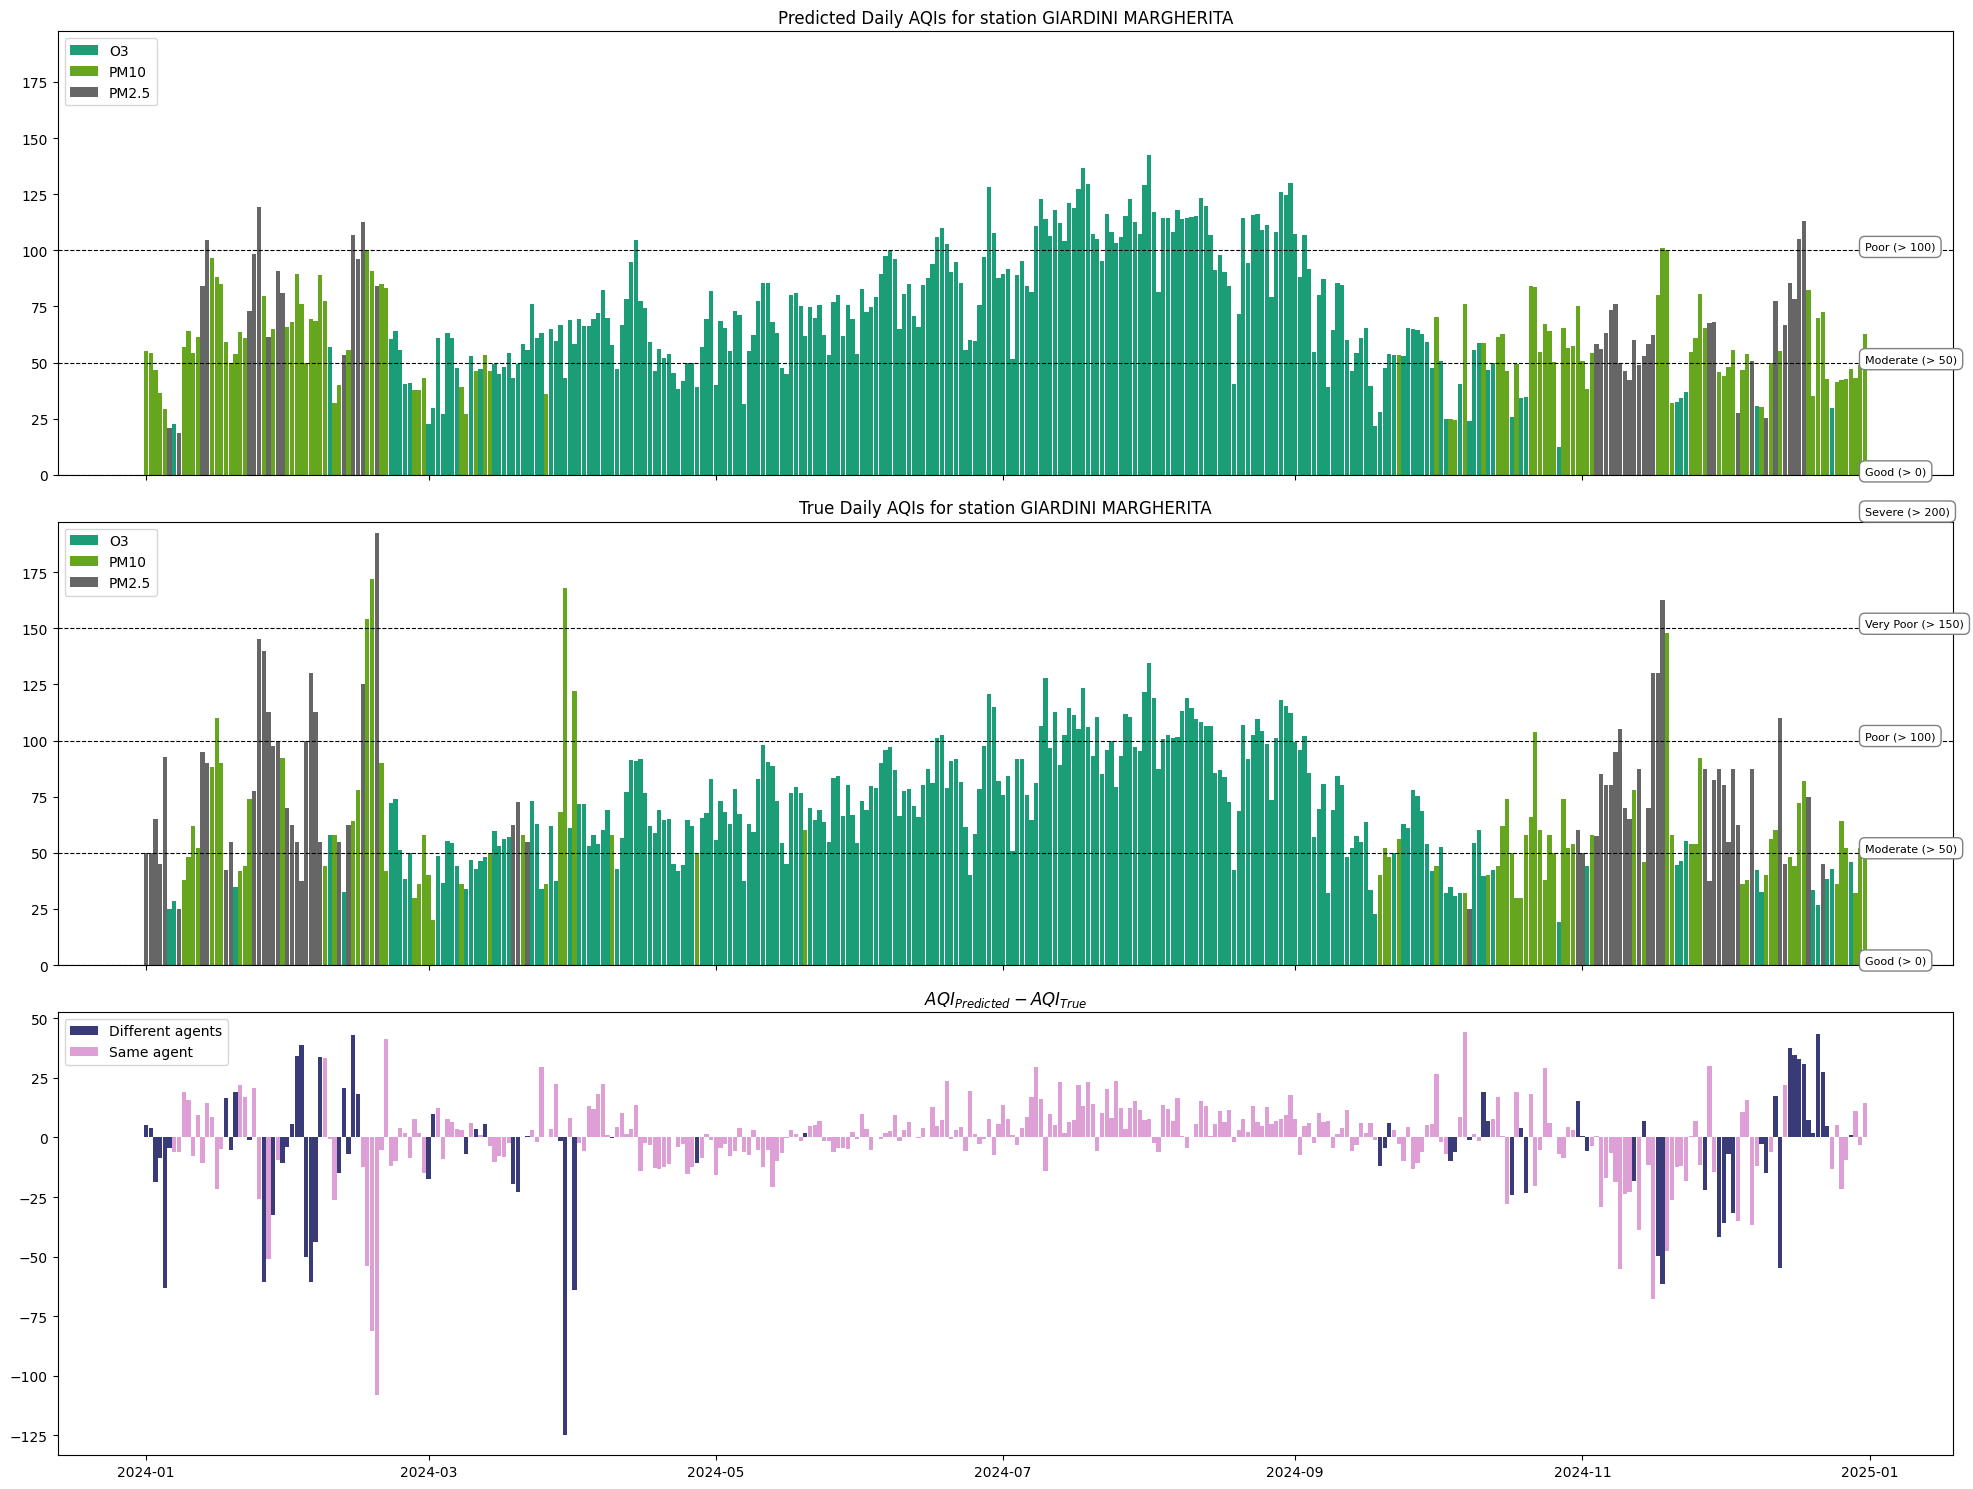

Station PORTA SAN FELICE AQI:


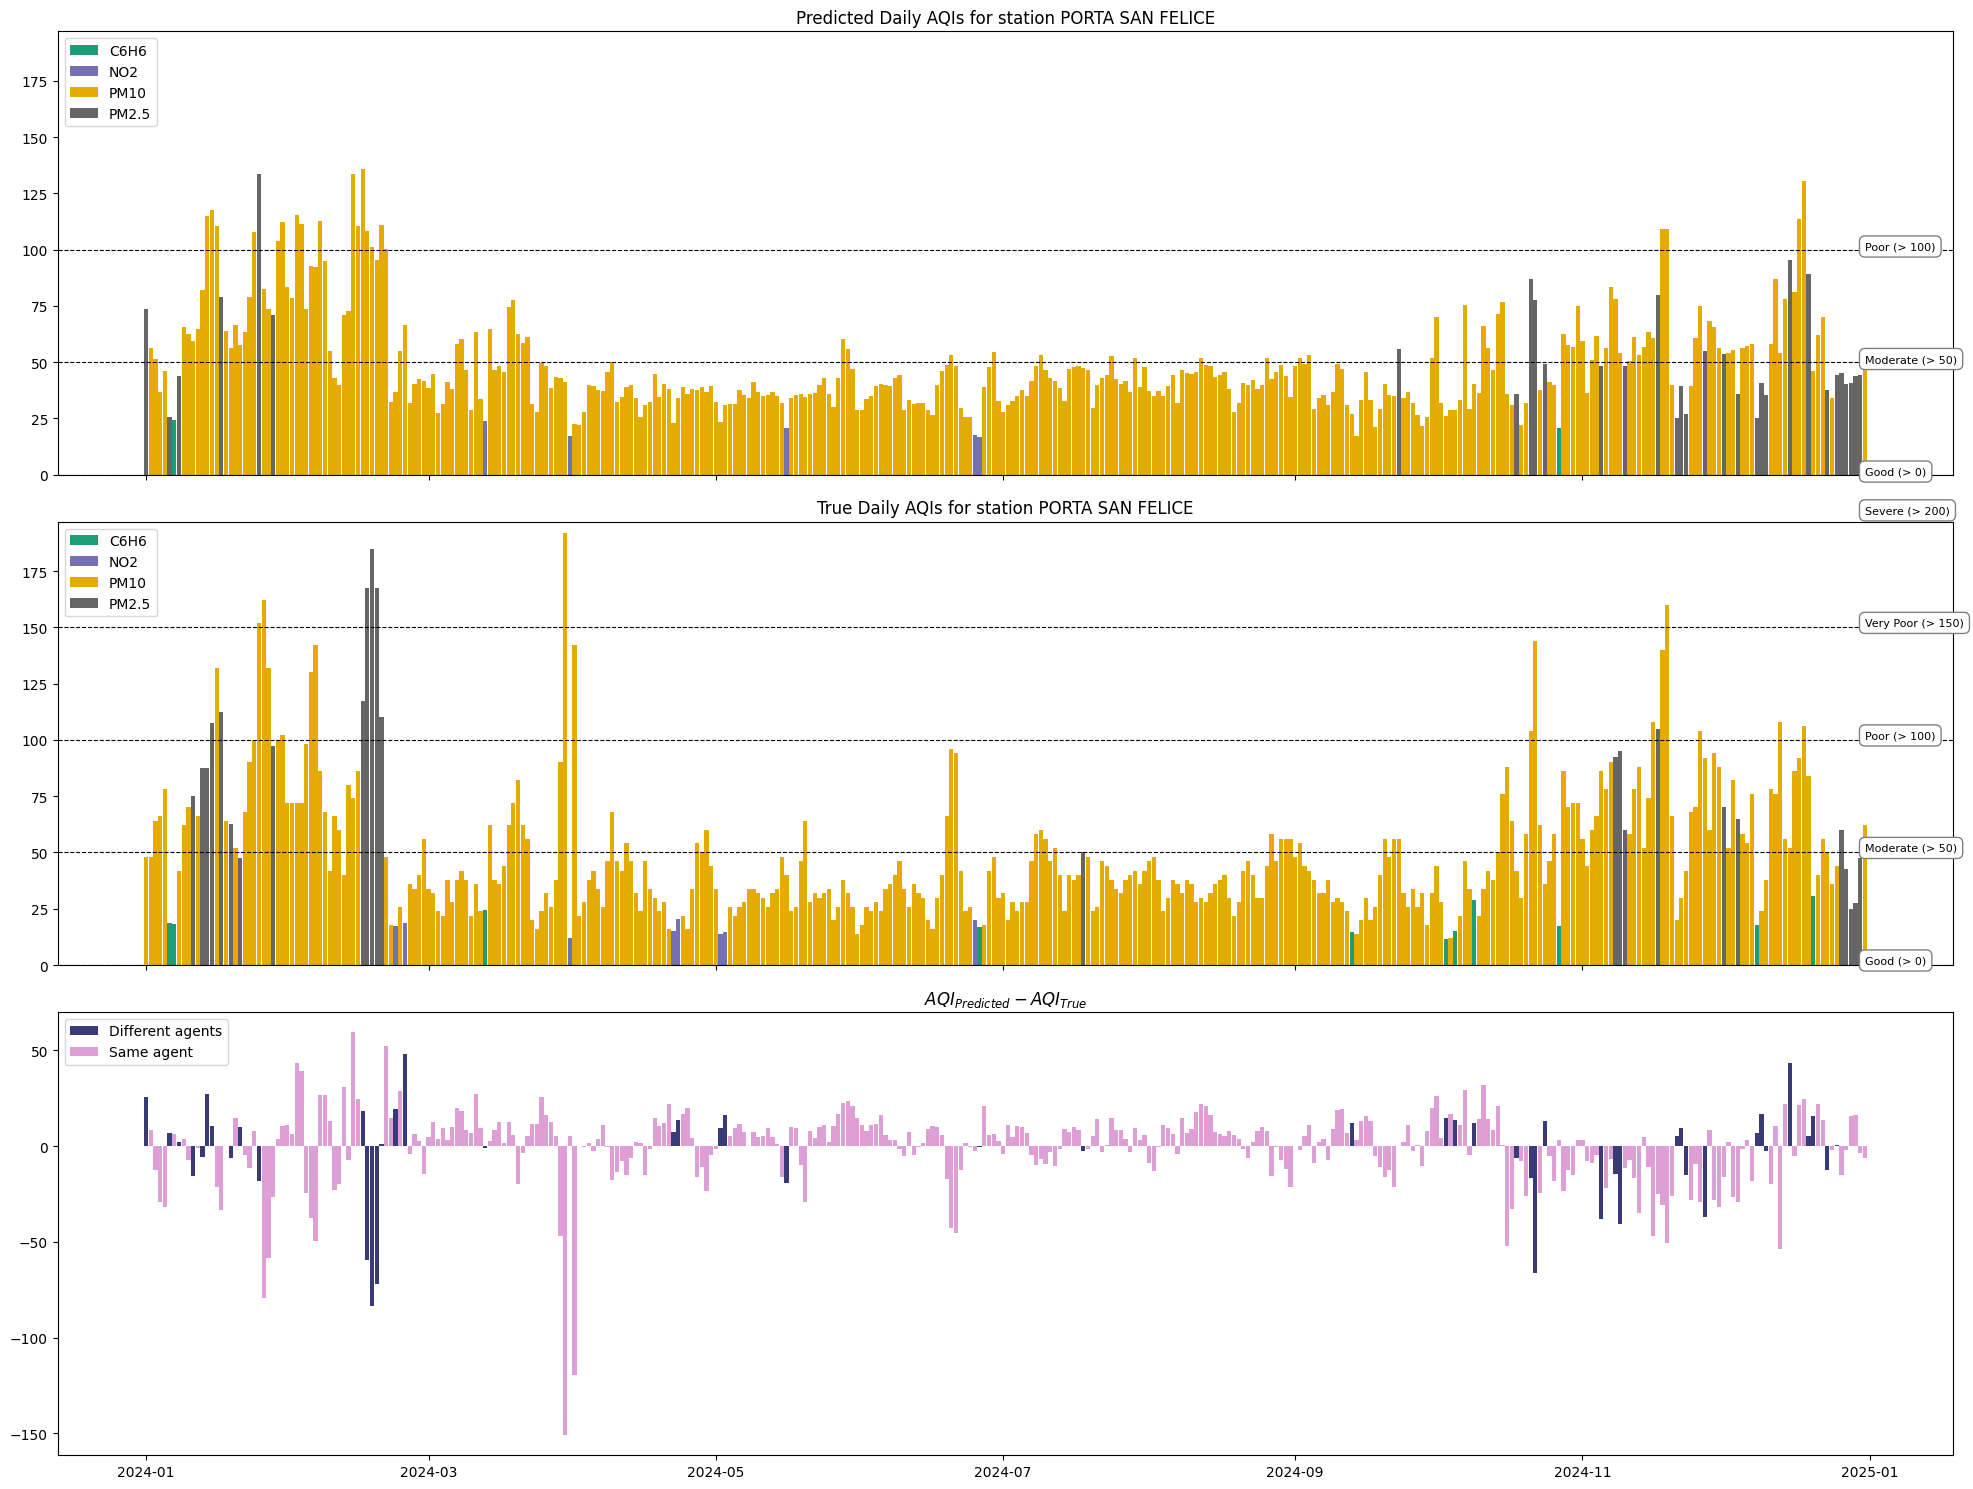

Station VIA CHIARINI AQI:


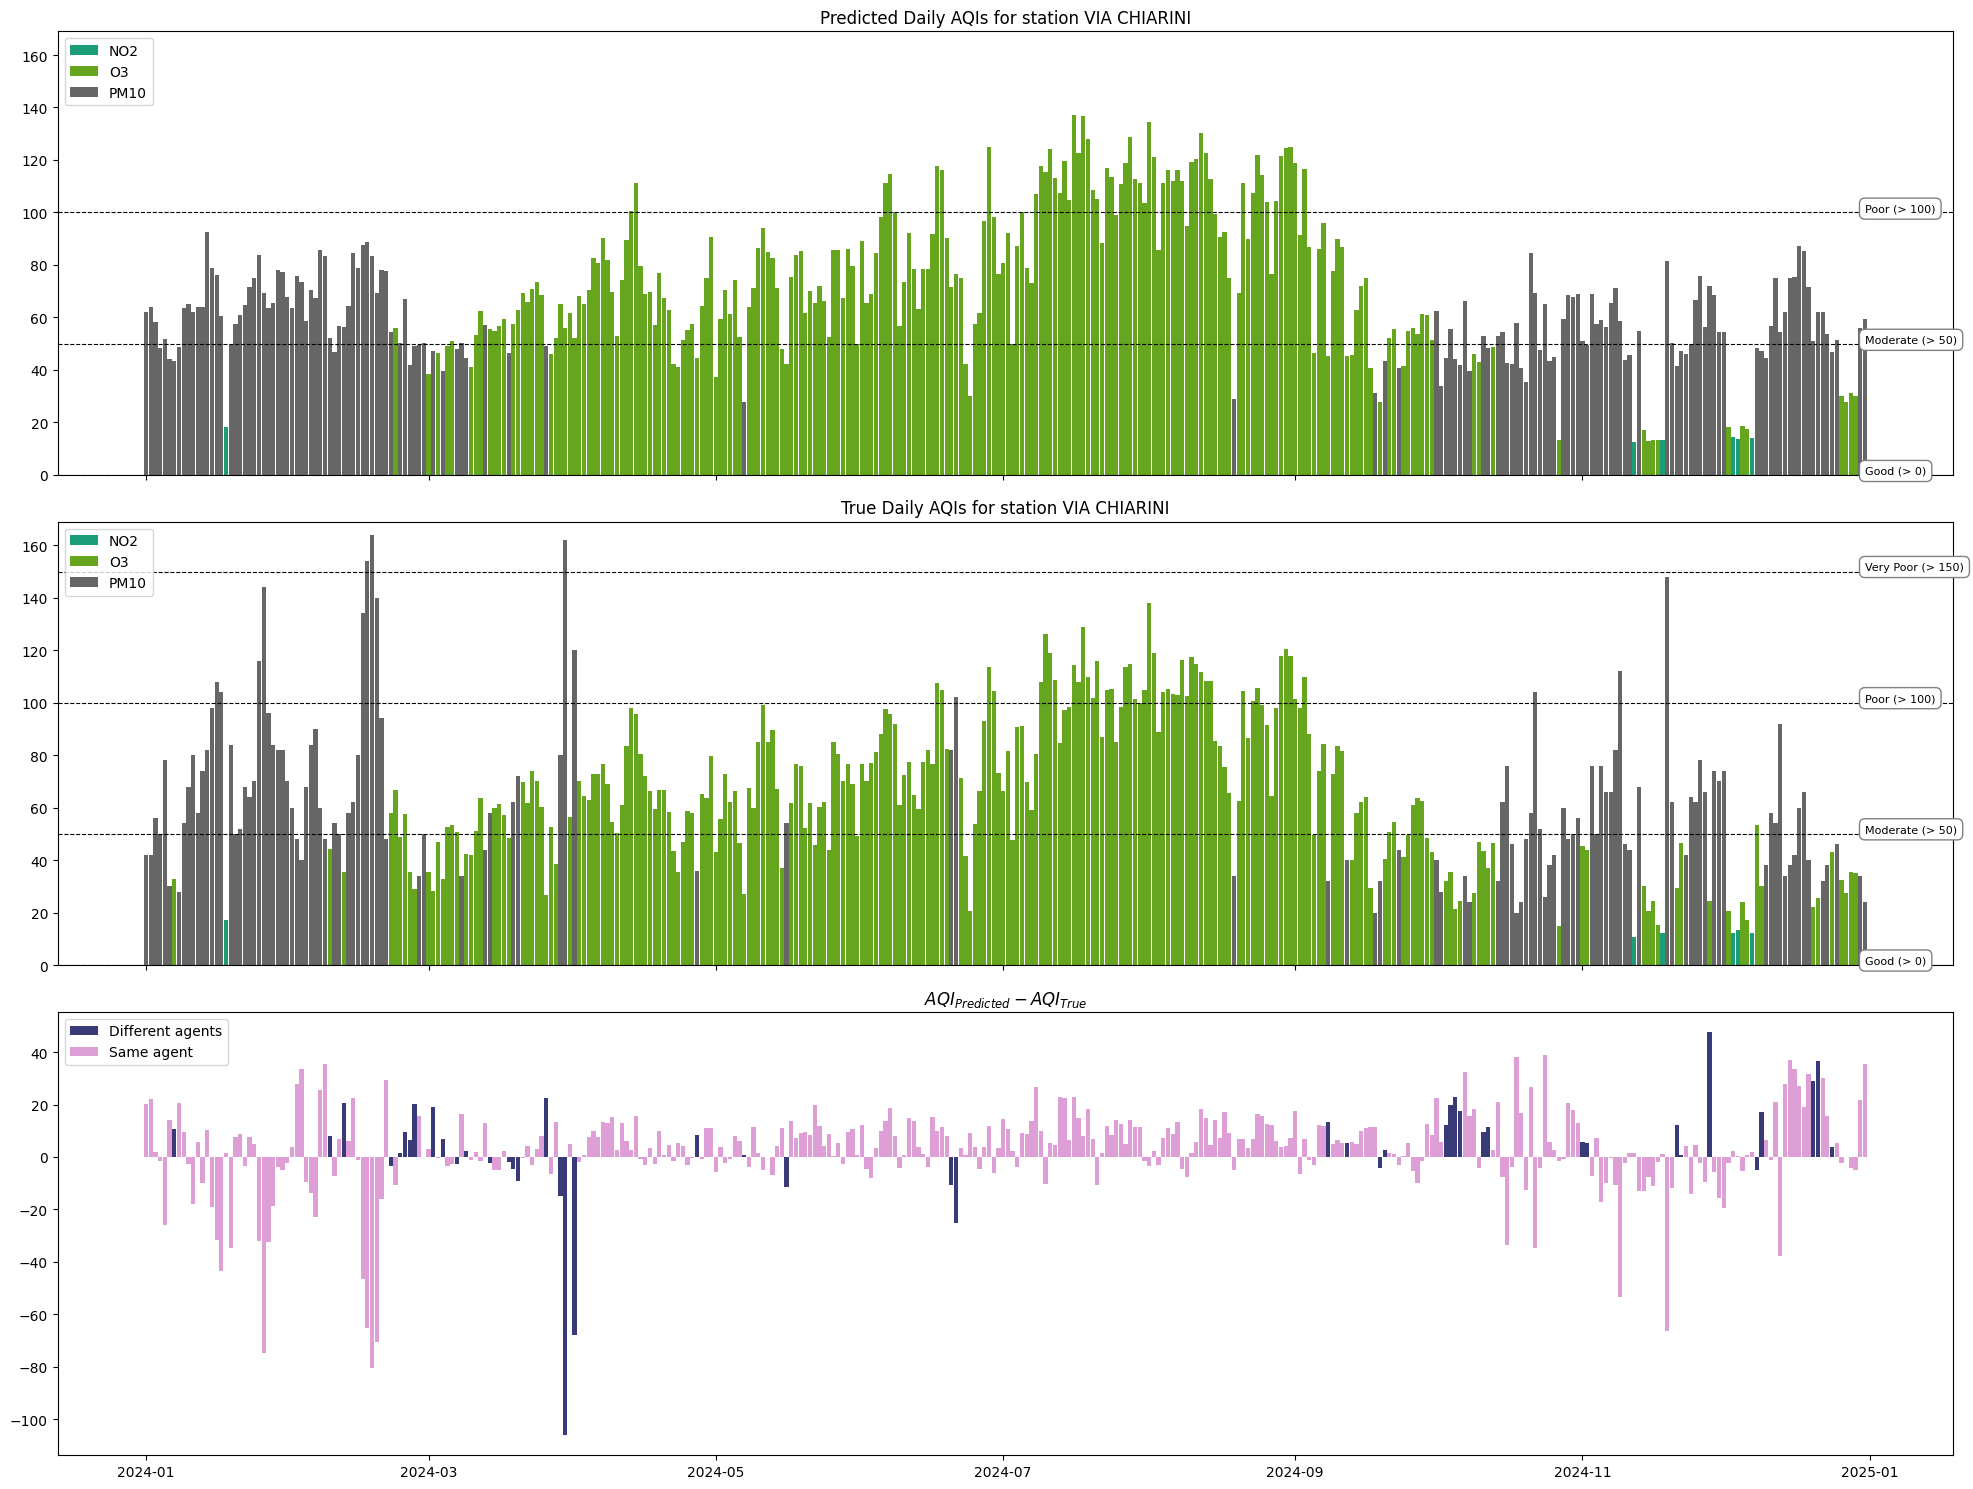

In [63]:
start=datetime(2024,1,1)
end=datetime(2024,12,31)

for station in true_AQIs_daily:
    print(f'Station {station} AQI:')
    plot_AQI(
        station_AQI=[
            pred_AQI_daily[station],
            true_AQI_daily[station],
            AQI_diff_daily[station]
        ], 
        title=[
            f'Predicted Daily AQIs for station {station}',
            f'True Daily AQIs for station {station}',
            r'$AQI_{Predicted} - AQI_{True}$'
        ], 
        categories=categories,
        figsize=(20, 5), s=start, e=end)

During the summer, it is easier to follow the correct AQI, moreover the models seem to perform really good. In the colder months sudden peaks are often present and are harder to predict.\
The plot also shows wich agents are responsible for the daily AQI value, and most of the times the pollutant in the true and predicted AQI match.\
O3 has said earlier impacts summer AQI a lot, but even in the  station where it is not present, the AQI trend is matched really nicely.

#### **Metrics**

Station GIARDINI MARGHERITA


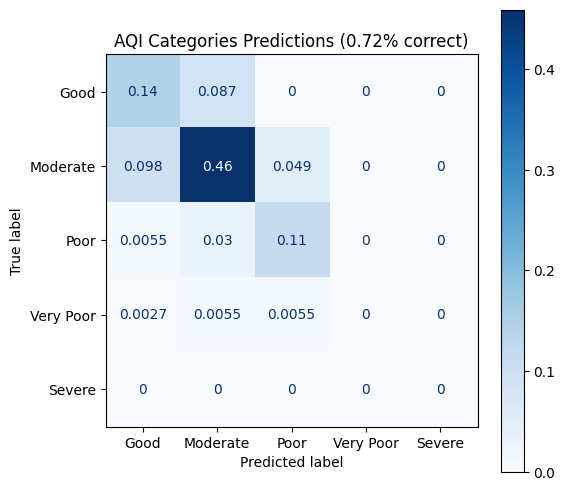

---------------------------------------------
> Absolute Mean AQI Difference: 13.01
> Positive Average AQI Difference: 10.81
> Negative Average AQI Difference: -15.54
> Percentage of Positive Differences: 53.55%
> Percentage of Negative Differences: 46.45%
> Percentage of Agent Values:
   - Same agent: 78.69
   - Different agents: 21.31
Station PORTA SAN FELICE


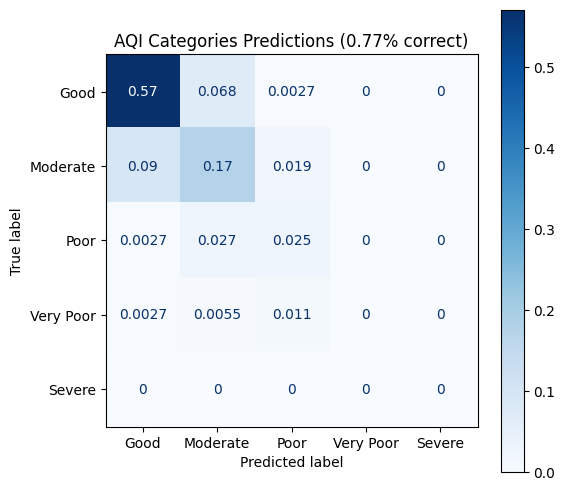

---------------------------------------------
> Absolute Mean AQI Difference: 14.38
> Positive Average AQI Difference: 11.53
> Negative Average AQI Difference: -18.40
> Percentage of Positive Differences: 58.47%
> Percentage of Negative Differences: 41.53%
> Percentage of Agent Values:
   - Same agent: 86.61
   - Different agents: 13.39
Station VIA CHIARINI


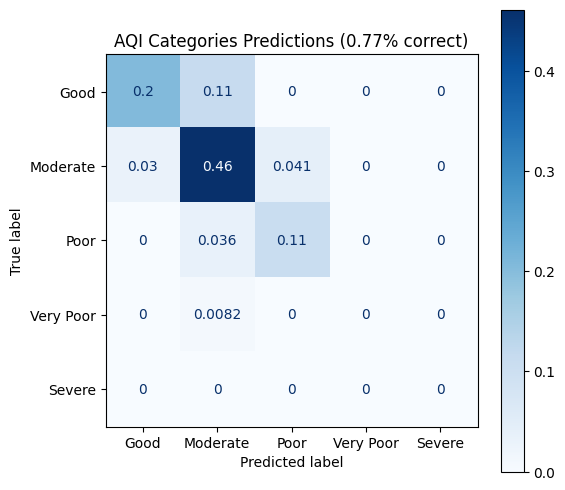

---------------------------------------------
> Absolute Mean AQI Difference: 11.67
> Positive Average AQI Difference: 11.09
> Negative Average AQI Difference: -12.78
> Percentage of Positive Differences: 65.57%
> Percentage of Negative Differences: 34.43%
> Percentage of Agent Values:
   - Same agent: 87.7
   - Different agents: 12.3


In [64]:
for station in stations:
    print('=============================================')
    print(f'Station {station}')
    print('=============================================')
    print_AQI_category_comparison(pred_AQI_daily[station],true_AQI_daily[station], categories=categories)
    print('---------------------------------------------')
    print_AQI_difference_metrics(AQI_diff_daily[station])
    print('=============================================')

Here, the categories distribution is more diverse. The models are able to predict values with correct AQI results more than 70% of the times.

We should also notice that when predicting daily AQI, we use the PM agents, trained on one data point for each day. This also means that those models might not be as accurate as the hourly ones. In facts, the daily AQI changes a lot when changing the daily models. Being able to train daily agents better might improve the daily accuracy.